<a href="https://colab.research.google.com/github/nguynlb/practice-d2l/blob/master/ComputerVision/ImageSegmentation%20/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install albumentations
!pip3 install segmentation_models_pytorch
!pip3 install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=de51e2fb60aededb9b99fd508e7701345e914c0f24d32f30b44a16fcfe842c02
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=9824fe332145e095f4a757c453c4674ec326afae5e904dd21dffa25567e739a0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [2]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2023-08-04 04:05:30--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-08-04 04:05:32--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  16.8MB/s    in 46s     

2023-08-04 04:06:19 (16.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-08-04 04:06:19--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.

In [3]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
from typing import Tuple, Dict, List


import os
from tqdm import tqdm

In [5]:
!pwd

/content


# Plot image


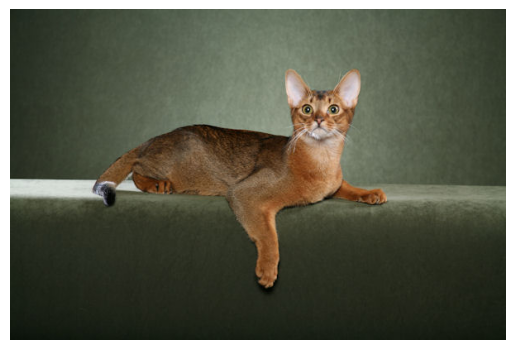

Shape of image: (400, 600, 3)


In [6]:
image_path = "/content/images/Abyssinian_1.jpg"
image = cv2.imread(image_path)
image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_cvt)
plt.axis(False)
plt.show();

print(f"Shape of image: {image_cvt.shape}")

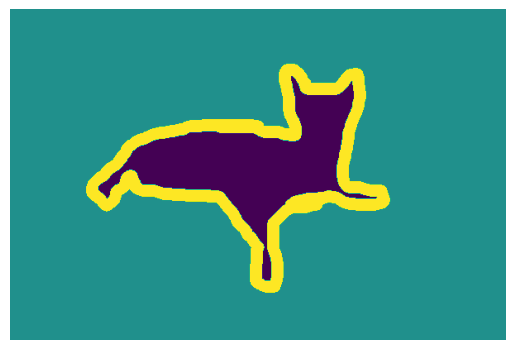

Shape of mark: (400, 600)


In [7]:
mark_path = "/content/annotations/trimaps/Abyssinian_1.png"
mark = cv2.imread(mark_path)
mark = cv2.cvtColor(mark, cv2.COLOR_BGR2GRAY)
plt.imshow(mark);
plt.axis(False)
plt.show();

print(f"Shape of mark: {mark.shape}")

del mark_path

# Custom Dataset

In [8]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir : str ,txt_file : str, transform : A.Compose = None) -> None:
    super().__init__()

    self.root_dir = root_dir
    self.txt_file = txt_file
    self.transform = transform
    self.list_image_path = []
    with open(txt_file, "r") as file:
      for line in file:
        self.list_image_path.append(line.split()[0])

  def __len__(self) -> int:
    return len(self.list_image_path)

  def __getitem__(self, idx: int) -> Tuple[np.ndarray | torch.Tensor]:
    # Read image
    image_path = os.path.join(self.root_dir, "images", f"{self.list_image_path[idx]}.jpg")
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Read mark
    mask_path = os.path.join(self.root_dir, "annotations", "trimaps" ,f"{self.list_image_path[idx]}.png")
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
    mask[mask == 2] = 0
    mask[mask == 3] = 1

    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      image = transformed['image']
      mask = transformed['mask']

    return image, mask



In [9]:
root_dir = "/content"
txt_file = "/content/annotations/trainval.txt"
dataset = DogCatDataset(root_dir=root_dir, txt_file=txt_file)

In [10]:
def denormalize_image(image: torch.Tensor) -> torch.Tensor:
  mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

  for i, m, s in zip(image, mean, std):
    i.mul_(s).add_(m)


  return image

In [11]:
def visualize_image_mark(dataset: DogCatDataset, n : int = 3,  seed: int = 82) -> None:
  """Visualize n-random picture and segmentation
  Args:
    - dataset: dataset want to visualize
    - n: number of picture
    - seed: seed random
  """
  np.random.seed(seed)
  size = len(dataset)

  fig, ax = plt.subplots(n, 2, figsize=(6, 6))

  for i in range(n):
    rand_idx = np.random.randint(size)
    image, mark = dataset[rand_idx]

    if isinstance(image, torch.Tensor):
      image = denormalize_image(image)
      image = image.permute(1, 2, 0)

    ax0 = ax[i, 0]
    ax0.imshow(image)
    ax0.set_title("Image")
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

    ax1 = ax[i, 1]
    ax1.imshow(mark)
    ax1.set_title("Segmentation")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)


  plt.show()

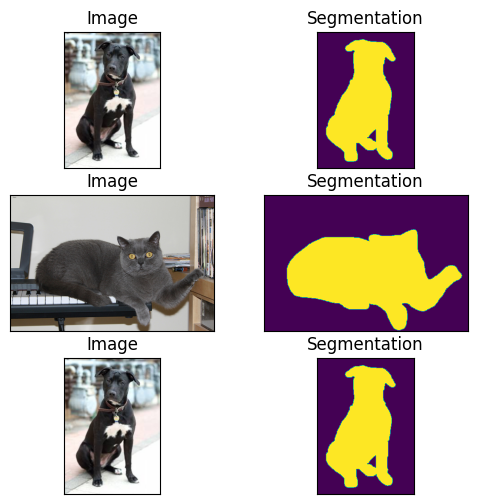

In [12]:
visualize_image_mark(dataset)

In [13]:
transform_size = 384

train_transform = A.Compose([
    A.Resize(width=transform_size, height=transform_size),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(width=transform_size, height=transform_size),
    A.Normalize(),
    ToTensorV2()
])

root_dir = "/content"
train_file = "/content/annotations/trainval.txt"
test_file = "/content/annotations/test.txt"

train_dataset = DogCatDataset(root_dir=root_dir,
                              txt_file=train_file,
                              transform=train_transform)

test_dataset = DogCatDataset(root_dir=root_dir,
                             txt_file=test_file,
                             transform=test_transform)


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


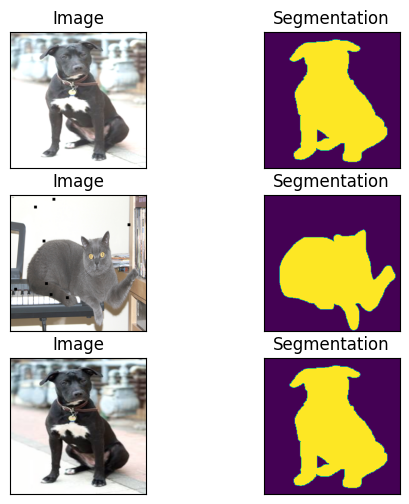

In [14]:
visualize_image_mark(dataset=train_dataset)

In [15]:
batch_size = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False,
                              pin_memory=True)



In [16]:
batch_image, batch_mask = next(iter(train_dataloader))

In [17]:
batch_image.shape, batch_mask.shape

(torch.Size([32, 3, 384, 384]), torch.Size([32, 384, 384]))

In [21]:
class UNet(nn.Module):
  def __init__(self, n_class: int, in_channels: int = 3, hidden_channels: List[int] = [64, 128, 256, 512, 1025]) -> None:
    super(UNet, self).__init__()

    if (len(hidden_channels) != 5):
      raise AttributeError(f"""
      UNet is implemented with 4 depth layers and 1 latent space.
      Size of hidden_channels must be 5. Find {len(hidden_channels)}
      """)

    def conv2d_block(in_channels, out_channels) -> nn.Module:
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding="same"),
          nn.ReLU(),
          nn.Conv2d(out_channels, out_channels, 3, padding="same"),
          nn.ReLU(),
      )


    self.n_class = n_class

    # Encoder block
    self.down_sample = nn.MaxPool2d(2)
    self.downblock_0 = conv2d_block(in_channels, hidden_channels[0])
    self.downblock_1 = conv2d_block(hidden_channels[0], hidden_channels[1])
    self.downblock_2 = conv2d_block(hidden_channels[1], hidden_channels[2])
    self.downblock_3 = conv2d_block(hidden_channels[2], hidden_channels[3])

    # Latent Space
    self.latent_block = conv2d_block(hidden_channels[3], hidden_channels[4])

    # Decoder block
    self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear')
    self.upblock_3 = conv2d_block(hidden_channels[4] + hidden_channels[3], hidden_channels[3])
    self.upblock_2 = conv2d_block(hidden_channels[3] + hidden_channels[2], hidden_channels[2])
    self.upblock_1 = conv2d_block(hidden_channels[2] + hidden_channels[1], hidden_channels[1])
    self.upblock_0 = conv2d_block(hidden_channels[1] + hidden_channels[0], hidden_channels[0])

    # Output
    self.output = nn.Conv2d(hidden_channels[0], self.n_class, 1, 1, 1)

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    # Encoder Block 0
    x0 = self.downblock_0(x)
    x = self.down_sample(x0)

    # Encoder Block 1
    x1 = self.downblock_1(x)
    x = self.down_sample(x1)

    # Encoder Block 2
    x2 = self.downblock_2(x)
    x = self.down_sample(x2)

    # Encoder Block 3
    x3 = self.downblock_3(x)
    x = self.down_sample(x3)

    # Latent Space
    x = self.latent_block(x)

    # Decoder Block 3
    x = self.up_sample(x)
    x = torch.cat((x3, x), dim = 1)
    x = self.upblock_3(x)

    # Decoder Block 2
    x = self.up_sample(x)
    x = torch.cat((x2, x), dim = 1)
    x = self.upblock_2(x)

    # Decoder Block 1
    x = self.up_sample(x)
    x = torch.cat((x1, x), dim = 1)
    x = self.upblock_1(x)

    # Decoder Block 0
    x = self.up_sample(x)
    x = torch.cat((x0, x), dim = 1)
    x = self.upblock_0(x)

    return self.output(x)

In [28]:
device = torch.device("cpu")

batch_image = batch_image.to(device)

In [ ]:
unet = UNet(n_class = 2, in_channels = 3).to(device)

unet(batch_image)